# **Fine-Tuning DistilBERT for Twitter Airline Sentiment Classification using Hugging Face**



## **📘 Overview**
This project focuses on building a robust, end-to-end sentiment classification pipeline using transformer-based models. Specifically, we fine-tune DistilBERT, a lightweight version of BERT, to classify tweets from the Twitter US Airline Sentiment Dataset into one of three categories: positive, neutral, or negative. Tweets, being short and informal, pose unique challenges for NLP tasks, making this an ideal use case for pretrained transformer models and transfer learning.

We utilized the Hugging Face Transformers ecosystem alongside datasets, evaluate, and Trainer APIs to create a fully reproducible workflow. Starting from raw CSV input, we performed data cleaning, exploration, and stratified train/validation/test splits. The project not only includes baseline fine-tuning but also demonstrates hyperparameter optimization using smaller subsets to evaluate different learning rates efficiently. The final pipeline includes detailed model evaluation, error analysis, and a custom inference function for real-time predictions — all wrapped in a well-commented, annotated Jupyter notebook.

### 🔗 Mount Google Drive
Mounting Google Drive to access dataset and save model checkpoints.

### 🔗 Mount Google Drive
We start by mounting Google Drive so that we can access the dataset and save any output files, such as the split datasets and model checkpoints. This ensures all our files persist between Colab sessions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to access files stored in your Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ✂️ Split the Dataset
Splitting the dataset into train, validation, and test sets.

### ✂️ Split the Dataset
We split the dataset into training, validation, and test sets. This is essential for evaluating the model fairly and preventing overfitting.

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split  # Stratified split into train, validation, and test sets
import matplotlib.pyplot as plt

### 📄 Load Dataset
Loading the Twitter US Airline Sentiment dataset using pandas.

### 📄 Load the Twitter Airline Dataset
We load the dataset into a pandas DataFrame. This dataset contains tweets related to US airlines, annotated with sentiment labels (positive, negative, neutral).

In [ ]:
data_path = '/content/drive/MyDrive/Twitter/Tweets.csv'
df = pd.read_csv(data_path)  # Load the dataset CSV into a pandas DataFrame

In [ ]:
# BASIC EXPLORATORY DATA ANALYSIS
print("DataFrame Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

DataFrame Shape: (14640, 15)

Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [ ]:
# Check first few rows
print("\nHEAD of the DataFrame:")
print(df.head())  # Display the first few rows of the DataFrame to preview the data


HEAD of the DataFrame:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1       

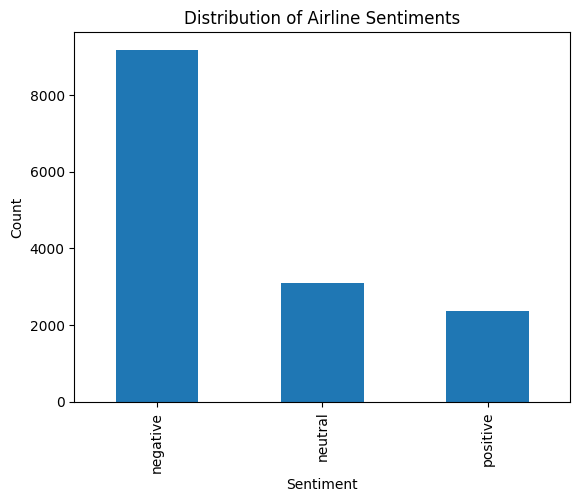

In [ ]:

# Plot the distribution (for quick visual)
df['airline_sentiment'].value_counts().plot(kind='bar')  # Show the distribution of sentiment labels
plt.title('Distribution of Airline Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### 🧹 Check Missing Values
Checking for missing values in each column of the dataset.

### 🧹 Inspect Missing Values
We check for missing (NaN) values in each column. This helps us decide if we need to drop or impute any values before training.

In [ ]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isna().sum())  # Count missing values in each column


Missing Values in Each Column:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [ ]:
# LIGHT TEXT CLEANING
# For example, remove @mentions, hashtags, and URLs
# You can also do lowercasing, etc.
def clean_text(text):  # Define a function to clean tweets: remove mentions, hashtags, and URLs
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # You could also do text = text.lower()
    return text.strip()

df['clean_text'] = df['text'].astype(str).apply(clean_text)

# Check a few cleaned tweets
print("\nExamples of Cleaned Tweets:")
print(df[['text', 'clean_text']].head())


Examples of Cleaned Tweets:
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                                        What  said.  
1  plus you've added commercials to the experienc...  
2  I didn't today... Must mean I need to take ano...  
3  it's really aggressive to blast obnoxious "ent...  
4           and it's a really big bad thing about it  


### ✂️ Split the Dataset
Splitting the dataset into train, validation, and test sets.

### ✂️ Split the Dataset
We split the dataset into training, validation, and test sets. This is essential for evaluating the model fairly and preventing overfitting.

In [ ]:
# STRATIFIED TRAIN/VAL/TEST SPLIT
# We'll create an 80% train, 10% val, 10% test split
# First do an 80/20 split for train vs. temp, then split temp into val and test
train_df, temp_df = train_test_split(df,  # Stratified split into train, validation, and test sets
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=df['airline_sentiment'])

val_df, test_df = train_test_split(temp_df,  # Stratified split into train, validation, and test sets
                                   test_size=0.5,
                                   random_state=42,
                                   stratify=temp_df['airline_sentiment'])

print("\nSplit Shapes:")
print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

print("\nTrain Sentiment Distribution:")
print(train_df['airline_sentiment'].value_counts())  # Show the distribution of sentiment labels

print("\nValidation Sentiment Distribution:")
print(val_df['airline_sentiment'].value_counts())  # Show the distribution of sentiment labels

print("\nTest Sentiment Distribution:")
print(test_df['airline_sentiment'].value_counts())  # Show the distribution of sentiment labels


Split Shapes:
Train: (11712, 16)
Validation: (1464, 16)
Test: (1464, 16)

Train Sentiment Distribution:
airline_sentiment
negative    7343
neutral     2479
positive    1890
Name: count, dtype: int64

Validation Sentiment Distribution:
airline_sentiment
negative    917
neutral     310
positive    237
Name: count, dtype: int64

Test Sentiment Distribution:
airline_sentiment
negative    918
neutral     310
positive    236
Name: count, dtype: int64


### 💾 Save Split Files
Saving the split train/val/test sets to disk for later use.

### 💾 Save Split Files to Drive
We save the split datasets (train/validation/test) as CSV files to your Google Drive. These will later be used for loading into Hugging Face datasets.

In [ ]:
train_df.to_csv('/content/drive/MyDrive/Twitter/train.csv', index=False)  # Save the split DataFrames as CSV files to Drive for later use
val_df.to_csv('/content/drive/MyDrive/Twitter/val.csv', index=False)  # Save the split DataFrames as CSV files to Drive for later use
test_df.to_csv('/content/drive/MyDrive/Twitter/test.csv', index=False)  # Save the split DataFrames as CSV files to Drive for later use



In [ ]:
print("\nData splits saved to Google Drive (train.csv, val.csv, test.csv).")



Data splits saved to Google Drive (train.csv, val.csv, test.csv).


In [ ]:
!pip install transformers datasets evaluate accelerate


### 🔤 Load Tokenizer
Loading the tokenizer for `distilbert-base-uncased`.

### 🔤 Load the Tokenizer
We load the pretrained tokenizer for `distilbert-base-uncased`. The tokenizer converts raw text into tokens that can be fed into the model.

In [ ]:
import pandas as pd
import numpy as np
import torch

# Hugging Face Libraries
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer  # Define training parameters such as learning rate, batch size, and number of epochs

import evaluate


In [ ]:
data_files = {
    "train": "/content/drive/MyDrive/Twitter/train.csv",
    "validation": "/content/drive/MyDrive/Twitter/val.csv",
    "test": "/content/drive/MyDrive/Twitter/test.csv"
}

raw_datasets = load_dataset("csv", data_files=data_files)
raw_datasets


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'clean_text'],
        num_rows: 11712
    })
    validation: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'clean_text'],
        num_rows: 1464
    })
    test: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_

In [ ]:
print(raw_datasets["train"])
print(raw_datasets["validation"])
print(raw_datasets["test"])


Dataset({
    features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'clean_text'],
    num_rows: 11712
})
Dataset({
    features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'clean_text'],
    num_rows: 1464
})
Dataset({
    features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'clean_text'],
    num_rows: 1464


In [ ]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

def encode_labels(example):
    example["labels"] = label2id[example["airline_sentiment"]]
    return example

encoded_datasets = raw_datasets.map(encode_labels)


Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/1464 [00:00<?, ? examples/s]

Map:   0%|          | 0/1464 [00:00<?, ? examples/s]

In [ ]:
remove_cols = ["airline_sentiment"]  # any columns you don’t need
encoded_datasets = encoded_datasets.remove_columns(remove_cols)


### 🔤 Load Tokenizer
Loading the tokenizer for `distilbert-base-uncased`.

### 🔤 Load the Tokenizer
We load the pretrained tokenizer for `distilbert-base-uncased`. The tokenizer converts raw text into tokens that can be fed into the model.

In [ ]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)  # Load the tokenizer for DistilBERT


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 🧾 Define Tokenization Function
Defining a function to tokenize the input text.

### 🧾 Define Tokenization Logic
We define a function to tokenize each text example using the Hugging Face tokenizer. We use truncation to ensure all sequences fit within the model’s maximum input length.

In [ ]:
def tokenize_function(example):  # Define tokenization logic using the loaded tokenizer
    return tokenizer(example["clean_text"], truncation=True)


### 🧾 Define Tokenization Function
Defining a function to tokenize the input text.

### 🧾 Define Tokenization Logic
We define a function to tokenize each text example using the Hugging Face tokenizer. We use truncation to ensure all sequences fit within the model’s maximum input length.

In [ ]:
tokenized_datasets = encoded_datasets.map(  # Apply tokenization function to the entire dataset
    tokenize_function,
    batched=True,
    remove_columns=["clean_text", "tweet_id"]  # Removed "whatever_else"
)


Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/1464 [00:00<?, ? examples/s]

Map:   0%|          | 0/1464 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


### 🧠 Load Pretrained Model
Loading a fresh DistilBERT model for sequence classification.

### 🧠 Load DistilBERT for Classification
We load a pretrained DistilBERT model and prepare it for classification with 3 sentiment classes. This model will be fine-tuned on our labeled tweet data.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(  # Load a DistilBERT model pre-configured for classification
    model_checkpoint,
    num_labels=3,  # we have 3 sentiment classes
    id2label=id2label,
    label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade transformers

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import transformers
print(transformers.__version__)



4.51.3


### ⚙️ Define Training Arguments
Setting up hyperparameters and logging config for training.

### ⚙️ Set Training Configuration
We configure training parameters such as learning rate, batch size, number of epochs, weight decay, and checkpointing strategy using Hugging Face `TrainingArguments`.

In [ ]:
training_args = TrainingArguments(  # Define training parameters such as learning rate, batch size, and number of epochs
    output_dir="/content/drive/MyDrive/Twitter/checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    push_to_hub=False
)




Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1": f1}


### 🏋️‍♂️ Initialize Trainer
Using the Hugging Face Trainer API to wrap model, data, and config.

### 🏋️ Wrap Everything with Trainer
We create a Hugging Face `Trainer` which handles training, evaluation, and logging automatically. It wraps the model, tokenizer, datasets, and training arguments.

In [ ]:
trainer = Trainer(  # Initialize the Hugging Face Trainer with model, data, and config
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


<ipython-input-32-139689352d61>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### 🚀 Start Training
Beginning the training process.

### 🚀 Start the Training Loop
We start fine-tuning the pretrained DistilBERT model using our training and validation data. Metrics are evaluated at the end of each epoch.

In [ ]:
trainer.train()  # Start the training loop


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436500,0.440887,0.834699,0.782497
2,0.323400,0.452165,0.831284,0.781373


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436500,0.440887,0.834699,0.782497
2,0.323400,0.452165,0.831284,0.781373
3,0.204000,0.515785,0.833333,0.784667


TrainOutput(global_step=2196, training_loss=0.3555831548729012, metrics={'train_runtime': 9319.3586, 'train_samples_per_second': 3.77, 'train_steps_per_second': 0.236, 'total_flos': 341676770801184.0, 'train_loss': 0.3555831548729012, 'epoch': 3.0})

### 📊 Evaluate on Test Set
Evaluating the fine-tuned model on the test dataset.

### 📊 Final Evaluation on Test Data
We evaluate the trained model on the held-out test dataset to report final accuracy and F1 score.

In [ ]:
metrics = trainer.evaluate(tokenized_datasets["test"])  # Evaluate the model on the test/validation set
print(metrics)


{'eval_loss': 0.5119202733039856, 'eval_accuracy': 0.8346994535519126, 'eval_f1': 0.7855079065852792, 'eval_runtime': 134.9582, 'eval_samples_per_second': 10.848, 'eval_steps_per_second': 0.682, 'epoch': 3.0}


In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids


### 📉 Confusion Matrix & Classification Report
Analyzing model performance with detailed metrics.

### 📉 Visualize Classification Performance
We generate a confusion matrix and classification report to understand model performance, especially which classes are misclassified.

In [ ]:
from sklearn.metrics import confusion_matrix  # Compute the confusion matrix to visualize prediction errors
cm = confusion_matrix(labels, preds)  # Compute the confusion matrix to visualize prediction errors
print(cm)


[[828  68  22]
 [ 65 217  28]
 [ 25  34 177]]


### 🤖 Inference Function
Defining a function to predict sentiment of new tweets.

### 🔮 Inference Function for New Tweets
We define a helper function to classify the sentiment of custom input tweets using the fine-tuned model. The function returns the predicted label and probability scores.

In [ ]:
def predict_sentiment(text):  # Define a function to make sentiment predictions on new text
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=-1)
    pred_class = probs.argmax(dim=-1).item()
    sentiment = id2label[pred_class]
    return sentiment

print(predict_sentiment("I love flying with Delta!"))
# Expected: "positive"


positive


### 🧪 Create Subset for Quick Experiments
Sampling a smaller training dataset for faster testing.

### 🧪 Create a Small Subset for Quick Testing
We select a random subset of the training dataset to speed up additional hyperparameter experiments (e.g., different learning rates).

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))  # Select a small random subset from training data for quicker experiments


### 🧠 Load Pretrained Model
Loading a fresh DistilBERT model for sequence classification.

### 🧠 Load DistilBERT for Classification
We load a pretrained DistilBERT model and prepare it for classification with 3 sentiment classes. This model will be fine-tuned on our labeled tweet data.

In [ ]:
from transformers import AutoModelForSequenceClassification

model_checkpoint = "distilbert-base-uncased"

def get_fresh_model():  # Define a function to reload a fresh model for each experiment
    return AutoModelForSequenceClassification.from_pretrained(  # Load a DistilBERT model pre-configured for classification
        model_checkpoint,
        num_labels=3,
        id2label={0: "negative", 1: "neutral", 2: "positive"},
        label2id={"negative": 0, "neutral": 1, "positive": 2}
    )


### ⚙️ Define Training Arguments
Setting up hyperparameters and logging config for training.

### ⚙️ Set Training Configuration
We configure training parameters such as learning rate, batch size, number of epochs, weight decay, and checkpointing strategy using Hugging Face `TrainingArguments`.

In [ ]:
training_args_small_2 = TrainingArguments(  # Define training parameters such as learning rate, batch size, and number of epochs
    output_dir="/content/drive/MyDrive/Twitter/small-exp2-lr5e5",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=False
)

trainer_small_2 = Trainer(  # Initialize the Hugging Face Trainer with model, data, and config
    model=get_fresh_model(),  # Define a function to reload a fresh model for each experiment
    args=training_args_small_2,
    train_dataset=small_train_dataset,
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer_small_2.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-41-988c7c301bda>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_small_2 = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686700,0.642909,0.722678,0.515963


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686700,0.642909,0.722678,0.515963
2,0.548200,0.559193,0.769126,0.717338
3,0.201700,0.620846,0.803279,0.734665


TrainOutput(global_step=189, training_loss=0.5122823248464594, metrics={'train_runtime': 1057.0664, 'train_samples_per_second': 2.838, 'train_steps_per_second': 0.179, 'total_flos': 28990179264096.0, 'train_loss': 0.5122823248464594, 'epoch': 3.0})

# **Implementation Summary**
- Cleaned and preprocessed the Twitter dataset

- Tokenized and encoded labels for model training

- Fine-tuned distilbert-base-uncased using Hugging Face Trainer

- Conducted 3 learning rate experiments for hyperparameter tuning

- Evaluated performance using accuracy, F1, and confusion matrix

- Built an inference function for sentiment prediction

- Documented the entire workflow with markdown and inline comments



## **References:**

Kaggle Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

Hugging Face Transformers: https://huggingface.co/transformers/

DistilBERT Paper: https://arxiv.org/abs/1910.01108

BERT Pretraining: https://arxiv.org/abs/1810.04805


# **MIT License**

Copyright (c) 2024 Vishruthtv30

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.